# Memory plots for Tegrastats logs

#### Globals and imports

In [12]:
import re
import matplotlib.pyplot as plt

### Functions

In [13]:
# Función para analizar una línea de estadísticas
# 03-17-2024 18:54:10 RAM 10239/62841MB (lfb 442x4MB) SWAP 1/31421MB (cached 0MB) CPU [0%@1728,0%@1728,0%@1728,0%@1728,0%@1420,0%@1420,0%@1420,0%@1420,off,off,off,off] GR3D_FREQ 0% cpu@37.5C tboard@27C soc2@34.562C tdiode@27.5C soc0@34.531C tj@37.5C soc1@33.656C VDD_GPU_SOC 1592mW/1592mW VDD_CPU_CV -398mW/-398mW VIN_SYS_5V0 2624mW/2624mW VDDQ_VDD2_1V8AO 403mW/403mW
def parse_line(line):
    stats = {}
    parts = line.split()
    stats['time'] = parts[0] + ' ' + parts[1]
    stats['RAM'] = int(parts[3].split('/')[0])
    stats['maxRAM'] = int(parts[3].split('/')[1].split('M')[0])
    stats['SWAP'] = int(parts[7].split('/')[0])
    stats['maxSWAP'] = int(parts[7].split('/')[1].split('M')[0])
    stats['CPU'] = parts[11].strip('[]').split(',')
    stats['GR3D_FREQ'] = int(parts[13].split('%')[0])
    # Agrega aquí más métricas según sea necesario.
    return stats

In [14]:
# Leer datos de los archivos y almacenar en diccionarios
def read_data(file_path):
    data = {'time': [], 'RAM': [], 'SWAP': [], 'GR3D_FREQ': [], 'CPU': [], 'CPU_FREQ': [], 'maxRAM': 0, 'maxSWAP': 0}
    with open(file_path, 'r') as file:
        first_line = True
        time_ms = 0  # Inicializa el contador de tiempo en 0
        for line in file:
            if line.strip():
                stats = parse_line(line)
                if first_line:
                    # Extrae maxRAM y maxSWAP solo de la primera línea
                    data['maxRAM'] = stats['maxRAM']
                    data['maxSWAP'] = stats['maxSWAP']
                    first_line = False
                 # Calcula el promedio del uso de CPU y la frecuencia
                cpu_usage_sum = 0
                cpu_freq_sum = 0
                cpu_count = 0
                for cpu in stats['CPU']:
                    if cpu != 'off':
                        usage, freq = cpu.split('@')
                        cpu_usage_sum += int(usage[:-1])  # Elimina el signo % y convierte a int
                        cpu_freq_sum += int(freq)
                        cpu_count += 1
                
                # Solo añade valores si hay CPUs activos
                if cpu_count > 0:
                    avg_cpu_usage = cpu_usage_sum / cpu_count
                    avg_cpu_freq = cpu_freq_sum / cpu_count
                else:
                    avg_cpu_usage = 0
                    avg_cpu_freq = 0

                data['CPU'].append(avg_cpu_usage)
                data['CPU_FREQ'].append(avg_cpu_freq)
                data['time'].append(time_ms)
                data['RAM'].append(stats['RAM'])
                data['SWAP'].append(stats['SWAP'])
                data['GR3D_FREQ'].append(stats['GR3D_FREQ'])
                # Incrementa el contador de tiempo en 1 milisegundo para el siguiente registro
                time_ms += 1 # estamos probando tegrastats a una taza de sampleo de 1 ms
    return data

In [15]:
def plot_memory_one_run_compare(metrics, labels, title):
    # Extraer maxRAM y maxSWAP de los datos (asumiendo que son constantes)
    maxRAM = metrics[0]['maxRAM'] / 1024  # Convertir de MB a GB
    maxSWAP = metrics[0]['maxSWAP'] / 1024  # Convertir de MB a GB

    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 7)).tight_layout()
    color_dict = {'Vanilla':'tab:blue', 'TRT fp32':'tab:orange', 'TRT fp16':'tab:green', 'TRT int8':'tab:red'}  # Añadir más etiquetas si es necesario

    # Graficar RAM
    for index, (metric, label) in enumerate(zip(metrics, labels)):
        ram_in_gb = [ram / 1024 for ram in metric['RAM']]  # Convertir RAM a GB
        color = color_dict.get(label, None)  # Obtener color del diccionario o usar el predeterminado
        plt.plot(metric['time'], ram_in_gb, label=f'RAM {label}', color=color)
        max_ram = max(ram_in_gb)
        avg_ram = sum(ram_in_gb) / len(ram_in_gb)

        #print(f'Max RAM {label}: {max_ram:.2f} GB, Avg RAM {label}: {avg_ram:.2f} GB')

    # Graficar SWAP
    for index, (metric, label) in enumerate(zip(metrics, labels)):
        swap_in_gb = [swap / 1024 for swap in metric['SWAP']]  # Convertir SWAP a GB
        color = color_dict.get(label, None)  # Obtener el mismo color para la misma etiqueta
        plt.plot(metric['time'], swap_in_gb, label=f'SWAP {label}', linestyle='--', color=color)  # Línea punteada para SWAP
        max_swap = max(swap_in_gb)
        avg_swap = sum(swap_in_gb) / len(swap_in_gb)

        #print(f'Max SWAP {label}: {max_swap:.2f} GB, Avg SWAP {label}: {avg_swap:.2f} GB')

    # Configurar título y etiquetas
    
    plt.title(f'{title} - RAM and SWAP Usage')
    plt.xlabel('Time ms')
    plt.ylabel('Usage (GB)')
    plt.ylim(0, max(maxRAM, maxSWAP))  # Asegurar que el eje Y sea adecuado para ambas series
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Mostrar gráfico
    plt.show()


In [16]:
def plot_memory_batch_size_compare(data_dicts, batch_sizes):
    """
    Plots average and maximum RAM and SWAP usage for multiple neural network models and prints max RAM and SWAP usage.
    
    Parameters:
    - data_dicts: List of dictionaries containing resource usage data.
    - batch_sizes: List of batch sizes corresponding to each dictionary.
    """
    maxRAM = data_dicts[0]['maxRAM'] / 1024  # Convertir de MB a GB
    maxSWAP = data_dicts[0]['maxSWAP'] / 1024  # Convertir de MB a GB
    avg_ram_usage = []
    max_ram_usage = []
    avg_swap_usage = []
    max_swap_usage = []

    # Recorrer los diccionarios de datos y calcular los promedios y máximos
    for index, (data, label) in enumerate(zip(data_dicts, batch_sizes)):
        # Calcular el uso promedio y máximo de RAM
        ram_in_gb = [ram / 1024 for ram in data['RAM']] 
        avg_ram = sum(ram_in_gb) / len(ram_in_gb)
        max_ram = max(ram_in_gb)
        avg_ram_usage.append(avg_ram)
        max_ram_usage.append(max_ram)
        
        # Calcular el uso promedio de SWAP
        if any(data['SWAP']):  # Verifica si hay algún uso de SWAP
            avg_swap = sum(data['SWAP']) / len(data['SWAP'])
            max_swap = max(data['SWAP'])  # Calcular el uso máximo real de SWAP
            avg_swap_usage.append(avg_swap)
            max_swap_usage.append(max_swap)
        else:
            avg_swap_usage.append(0)  # Cambiado de None a 0 para el plot
            max_swap_usage.append(0)  # Cambiado de None a 0 para el plot

    # Plot RAM usage
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(5, 3.5)).tight_layout()
    plt.plot(batch_sizes, avg_ram_usage, label='Average RAM Usage', marker='o', color='tab:blue')
    plt.plot(batch_sizes, max_ram_usage, label='Max RAM Usage', linestyle='--', marker='o', color='tab:blue')
    plt.fill_between(batch_sizes, avg_ram_usage, max_ram_usage, color='tab:blue', alpha=0.2)  # Área sombreada entre RAM promedio y máxima
    max_ram_limit = max(max([ram / 1024 for ram in data['RAM']]) for data in data_dicts)
    #plt.ylim(0, 1.1*max_ram_limit)
    plt.ylim(0, 8)

    # Plot SWAP usage if any
    if any(max_swap_usage):  # Se verifica si hay algún valor distinto de 0 en max_swap_usage
        plt.plot(batch_sizes, avg_swap_usage, label='Average SWAP Usage', marker='x', color='tab:green')
        plt.plot(batch_sizes, max_swap_usage, label='Max SWAP Usage', linestyle='--', marker='x', color='tab:green')
        plt.fill_between(batch_sizes, avg_swap_usage, max_swap_usage, color='tab:green', alpha=0.2)  # Área sombreada entre SWAP promedio y máximo

    plt.xlabel('Batch Size')
    plt.ylabel('Usage (GB)')
    plt.title(f'{PLATFORM} {POWER_MODE} {NETWORK} {OPTIMIZATION}')
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'memory_{PLATFORM}_{POWER_MODE}_{NETWORK}_{OPTIMIZATION}.pdf', format='pdf', bbox_inches='tight')  # Guardar la figura
    plt.show()


In [17]:
def plot_memory_batch_size_compare_with_PM(data_dicts_pm, batch_sizes):
    """
    Plots average and maximum RAM and SWAP usage for multiple neural network models under different Power Modes.
    
    Parameters:
    - data_dicts_pm: List of lists of dictionaries containing resource usage data for different Power Modes.
    - batch_sizes: List of batch sizes corresponding to each dictionary.
    """
    
    # Configuración de colores y estilos para diferentes Power Modes
    colors = ['tab:blue', 'tab:orange', 'tab:green']  # Colores para diferentes Power Modes
   
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(5, 3.5))
    
    # Recorrer los conjuntos de datos para cada Power Mode
    
    for pm_index, data_dicts in enumerate(data_dicts_pm):
        avg_ram_usage = []
        max_ram_usage = []
        avg_swap_usage = []
        max_swap_usage = []
        
        # Recorrer cada batch size dentro del modo de energía actual
        for index, (data, label) in enumerate(zip(data_dicts, batch_sizes)):
            ram_in_gb = [ram / 1024 for ram in data['RAM']] 
            
            # Manejo de excepciones para evitar errores de división por cero
            if len(ram_in_gb) > 0:
                avg_ram = sum(ram_in_gb) / len(ram_in_gb)
                max_ram = max(ram_in_gb)
            else:
                avg_ram = 0
                max_ram = 0
                print(f"Advertencia: No hay datos de RAM para el batch size {label} en PM{pm_index}")
            
            avg_ram_usage.append(avg_ram)
            max_ram_usage.append(max_ram)
            
            # Calcular el uso promedio de SWAP (convertido a GB)
            if any(swap > 0 for swap in data['SWAP']):  # Validación de uso de SWAP
                swap_in_gb = [swap / 1024 for swap in data['SWAP']]
                avg_swap = sum(swap_in_gb) / len(swap_in_gb)
                max_swap = max(swap_in_gb)
            else:
                avg_swap = 0
                max_swap = 0
                print(f"Advertencia: No hay datos de SWAP para el batch size {label} en PM{pm_index}")
            
            avg_swap_usage.append(avg_swap)
            max_swap_usage.append(max_swap)
        
        # Plot RAM usage para el modo de energía actual
        color = colors[pm_index % len(colors)]
        plt.plot(batch_sizes, avg_ram_usage, label=f'Average RAM Usage PM{pm_index}', marker='o', color=color)
        plt.plot(batch_sizes, max_ram_usage, label=f'Max RAM Usage PM{pm_index}', linestyle="--", marker='o', color=color)
        plt.fill_between(batch_sizes, avg_ram_usage, max_ram_usage, color=color, alpha=0.2)  # Área sombreada entre RAM promedio y máxima
    
        # Plot SWAP usage if any para el modo de energía actual
        if any(max_swap_usage):
            plt.plot(batch_sizes, avg_swap_usage, label=f'Average SWAP Usage PM{pm_index}', marker='x', color=color)
            plt.plot(batch_sizes, max_swap_usage, label=f'Max SWAP Usage PM{pm_index}', linestyle="--", marker='x', color=color)
            plt.fill_between(batch_sizes, avg_swap_usage, max_swap_usage, color=color, alpha=0.2)  # Área sombreada entre SWAP promedio y máxima

    # Establecer límites en base al 'maxRAM' de los datos
    max_ram_limit = max([max([ram / 1024 for ram in data['RAM']]) for data_dicts in data_dicts_pm for data in data_dicts if data['RAM']])
    max_swap_limit = max([max([swap / 1024 for swap in data['SWAP']]) for data_dicts in data_dicts_pm for data in data_dicts if data['SWAP']], default=0)
    
    # Ajustar el límite superior del gráfico para incluir RAM y SWAP
    plt.ylim(0, max(max_ram_limit, max_swap_limit) * 1.1 if max_ram_limit > 0 else 8)  
    
    # Configuración del gráfico
    plt.xlabel('Batch Size')
    plt.ylabel('Usage (GB)')
    plt.title(f'{PLATFORM} {NETWORK} {OPTIMIZATION}')
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')
    plt.minorticks_on()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Memory_{PLATFORM}_{NETWORK}_{OPTIMIZATION}.pdf', format='pdf', bbox_inches='tight')
    plt.show()


# PLOTS

In [18]:
# Leer datos de cada optimización

PLATFORM = 'orin_agx'
POWER_MODE = 'PM2'
NETWORK = 'resnet50'
BATCH_SIZE = '256'

data_vanilla =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/vanilla_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}.txt')
data_trt_fp32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/fp32_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}.txt')
data_trt_fp16 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/fp16_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}.txt')
data_trt_int8  = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/int8_{NETWORK}_bs_{BATCH_SIZE}_{POWER_MODE}.txt')
# Graficar los datos
""" 
plot_memory_one_run_compare(
    [ data_vanilla, data_trt_fp32, data_trt_fp16,data_trt_int8],
    [ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT int8'],
    'MetricComparisonOveTrime'
) 
"""
#[ data_vanilla, data_trt_fp32, data_trt_fp16, data_trt_int8],
#[ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT INT8'],

" \nplot_memory_one_run_compare(\n    [ data_vanilla, data_trt_fp32, data_trt_fp16,data_trt_int8],\n    [ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT int8'],\n    'MetricComparisonOveTrime'\n) \n"

In [19]:
OPTIMIZATION = 'int8'
PLATFORM = 'orin_nano'
POWER_MODE = 'PM0'
NETWORK = 'resnet50'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE}.txt')

# Graficar los datos
""" 
plot_memory_batch_size_compare(
    [ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
    [ 1,32,64,128,256]
) 
"""

' \nplot_memory_batch_size_compare(\n    [ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],\n    [ 1,32,64,128,256]\n) \n'

In [20]:
# Leer datos de cada optimización

OPTIMIZATION = 'vanilla'
PLATFORM = 'orin_agx'
POWER_MODE = 'PM0'
POWER_MODE_1 = 'PM1'
POWER_MODE_2 = 'PM2'
NETWORK = 'resnet152'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE}.txt')

data_bs_1_PM =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE_1}.txt')
data_bs_32_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE_1}.txt')
data_bs_64_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE_1}.txt')
data_bs_128_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE_1}.txt')
data_bs_256_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE_1}.txt')

data_bs_1_PM2 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE_2}.txt')
data_bs_32_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE_2}.txt')
data_bs_64_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE_2}.txt')
data_bs_128_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE_2}.txt')
data_bs_256_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE_2}.txt')

# Graficar los datos
""" 
plot_memory_batch_size_compare_with_PM(
    [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
    [ data_bs_1_PM, data_bs_32_PM, data_bs_64_PM,data_bs_128_PM,data_bs_256_PM]
    ,[ data_bs_1_PM2, data_bs_32_PM2, data_bs_64_PM2,data_bs_128_PM2,data_bs_256_PM2]
    ],
    [ 1,32,64,128,256]
)
"""

' \nplot_memory_batch_size_compare_with_PM(\n    [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],\n    [ data_bs_1_PM, data_bs_32_PM, data_bs_64_PM,data_bs_128_PM,data_bs_256_PM]\n    ,[ data_bs_1_PM2, data_bs_32_PM2, data_bs_64_PM2,data_bs_128_PM2,data_bs_256_PM2]\n    ],\n    [ 1,32,64,128,256]\n)\n'

Advertencia: No hay datos de RAM para el batch size 256 en PM0
Advertencia: No hay datos de SWAP para el batch size 256 en PM0
Advertencia: No hay datos de SWAP para el batch size 1 en PM2


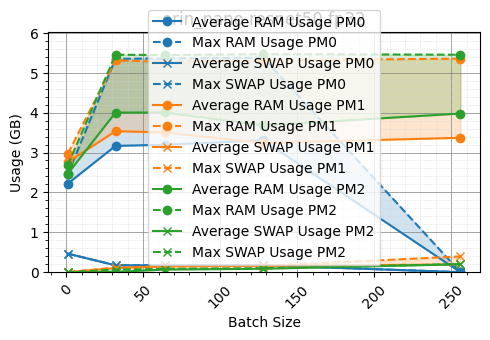

In [22]:
# Un uso de plot_memory_batch_size_compare_with_PM para graficar experimentos con batch size estatico/dinamico, es necesario cambiar unas lineas de la funcion que estan comentadas.

OPTIMIZATION = 'fp32'
PLATFORM = 'orin_nano'
POWER_MODE = 'PM0'
POWER_MODE_1 = 'PM0'
POWER_MODE_2 = 'PM0'
NETWORK = 'resnet50'

data_bs_1 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE}.txt')
data_bs_32 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE}.txt')
data_bs_64 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE}.txt')
data_bs_128 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE}.txt')
data_bs_256 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE}.txt')

data_bs_1_PM =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE_1}_OPLVL5.txt')
data_bs_32_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE_1}_OPLVL5.txt')
data_bs_64_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE_1}_OPLVL5.txt')
data_bs_128_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE_1}_OPLVL5.txt')
data_bs_256_PM = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE_1}_OPLVL5.txt')

data_bs_1_PM2 =  read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_1_{POWER_MODE_2}_OPLVL0.txt')
data_bs_32_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_32_{POWER_MODE_2}_OPLVL0.txt')
data_bs_64_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_64_{POWER_MODE_2}_OPLVL0.txt')
data_bs_128_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_128_{POWER_MODE_2}_OPLVL0.txt')
data_bs_256_PM2 = read_data(f'../outputs/tegrastats_log/tegrastats_log_{PLATFORM}/{OPTIMIZATION}_{NETWORK}_bs_256_{POWER_MODE_2}_OPLVL0.txt')

# Graficar los datos 
plot_memory_batch_size_compare_with_PM(
    [[ data_bs_1, data_bs_32, data_bs_64,data_bs_128,data_bs_256],
    [ data_bs_1_PM, data_bs_32_PM, data_bs_64_PM,data_bs_128_PM,data_bs_256_PM]
    ,[ data_bs_1_PM2, data_bs_32_PM2, data_bs_64_PM2,data_bs_128_PM2,data_bs_256_PM2]
    ],
    [ 1,32,64,128,256]
)